# Multiclass Automated Speech Recognition using a Baseline and an Advanced Model

### Prerequisites

* Download the speech image transformed data from GitHub and unzip it in the current directory:

In [43]:
# get the data from github and unzip
!wget https://raw.githubusercontent.com/andrsn/data/main/speechImageData.zip
!unzip -q /content/speechImageData.zip
!mv speechImageData\ -\ Copy speechImageData

--2024-03-19 08:58:45--  https://raw.githubusercontent.com/andrsn/data/main/speechImageData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9872924 (9.4M) [application/zip]
Saving to: ‘speechImageData.zip.1’

speechImageData.zip 100%[===================>]   9.42M  --.-KB/s    in 0.05s   

2024-03-19 08:58:45 (177 MB/s) - ‘speechImageData.zip.1’ saved [9872924/9872924]



* Install all the necessary libraries for our notebook

In [2]:
!pip install scikeras pydub

### 1. Import Libraries and define constants

We will start by importing the necessary libraries and defining the constants that will be used throughout the notebook.

In [1]:
import random
import shutil
import librosa
import soundfile as sf
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import optimizers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input, Conv2D, MaxPooling2D, Flatten
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

from pydub import AudioSegment
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval


NUM_CLASSES = 12
BATCH_SIZE = 128
IMG_SIZE = (98, 50)
TIMEPOOL_SIZE = 12

2024-03-23 00:11:59.563366: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 00:11:59.728089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 00:11:59.728141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 00:11:59.749755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 00:11:59.803515: I tensorflow/core/platform/cpu_feature_guar

### 2. Data Preprocessing

* Create usable keras dataset components from the extracted files.

* In total, there are 12 classes of different spoken words and the spectrograms, which form the input image data are of size 98x50 pixels.

In [3]:
# Load the data

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData/TrainData',
    labels='inferred',
    color_mode="grayscale",
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData/ValData',
    labels='inferred',
    color_mode="grayscale",
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Extract the training input images and output class labels
x_train = []
y_train = []
for images, labels in train_ds.take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(y_train)

# Extract the validation input images and output class labels
x_val = []
y_val = []
for images, labels in val_ds.take(-1):
    x_val.append(images.numpy())
    y_val.append(labels.numpy())

x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

print(y_val)


Found 2001 files belonging to 12 classes.


2024-03-23 00:12:21.204535: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 00:12:21.266861: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 00:12:21.267266: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 1171 files belonging to 12 classes.
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 3. Model Design

We now attempt to approach the problem with five tasks:

#### Task 1: Baseline Model

##### Model features:

The following are its features:

* The baseline model is a simple Convolutional Neural Network (CNN) with one input layer, four hidden layers, one fully connected layer and an output layer.
* The input layer consists of the following:

	* A Conv2D layer with 32 filters, a kernel size of 3x3, and a ReLU activation function.
	* A BatchNormalization layer.
	* A MaxPooling2D layer with a pool size of 2x2.

* The four hidden layers are replicated from the input layer.
* A time pooling layer is added to the model to combat the start time of the audio.
* The fully connected layer consists of 1024 units and a ReLU activation function.
* The output layer consists of 12 units and a softmax activation function.

##### Additional model hyperparameters:
* The model uses the Adam optimizer with a learning rate of 0.001.
* The L2 regularization parameter is set to 0.001.
* While training, an early stopping callback is used to stop the training process if the validation accuracy does not decrease for 5 epochs.

In [4]:
# define t1 model
def t1_model(num_layers, num_filters, passthrough=False):
    # number of convolutional filters
    input_num_filters = 32
    fully_connected_num_filters = 1024

    # define model
    model = Sequential()

    # input layer
    model.add(Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
    model.add(Conv2D(input_num_filters, kernel_size =(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # hidden layers
    for i in range(num_layers):
        if passthrough:
            model.add(Conv2D(num_filters[i], kernel_size =(3, 3), padding='same', activation='relu'))
        else:
            model.add(Conv2D(num_filters, kernel_size =(3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size =(2, 2), strides=(2, 2), padding='same'))

    # Time based pooling
    model.add(MaxPooling2D(pool_size=(TIMEPOOL_SIZE, 1), strides=(TIMEPOOL_SIZE, 1), padding='same'))

    # fully connected layer
    model.add(Flatten())
    model.add(Dense(fully_connected_num_filters, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dropout(0.2))

    # output layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # set adam optimizer
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    return model

hidden_num_layers = [2, 3, 4, 5]
hidden_num_filters = [128, 128, 128, 128]
task1_model = t1_model(len(hidden_num_layers), hidden_num_filters, passthrough=True)
task1_model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 50, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 98, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 50, 128)       36992     
                                                                 
 batch_normalization_1 (Bat  (None, 98, 50, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 25, 128)       0         
 D)                                                              
                                                        

#### T1.A - Model Training

This section trains the deep convolutional network using the Adam algorithm.

In [6]:
history = task1_model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=15, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/15
16/16 [==============================] - 17s 369ms/step - loss: 10.7208 - accuracy: 0.2474 - val_loss: 14.2474 - val_accuracy: 0.0863
Epoch 2/15
16/16 [==============================] - 2s 128ms/step - loss: 7.5581 - accuracy: 0.3433 - val_loss: 11.3006 - val_accuracy: 0.1204
Epoch 3/15
16/16 [==============================] - 2s 128ms/step - loss: 6.4265 - accuracy: 0.4693 - val_loss: 8.7848 - val_accuracy: 0.1588
Epoch 4/15
16/16 [==============================] - 2s 131ms/step - loss: 5.5289 - accuracy: 0.5722 - val_loss: 7.1032 - val_accuracy: 0.1742
Epoch 5/15
16/16 [==============================] - 2s 135ms/step - loss: 4.6883 - accuracy: 0.6972 - val_loss: 5.4696 - val_accuracy: 0.3348
Epoch 6/15
16/16 [==============================] - 2s 132ms/step - loss: 3.9862 - accuracy: 0.7841 - val_loss: 4.8391 - val_accuracy: 0.4056
Epoch 7/15
16/16 [==============================] - 2s 132ms/step - loss: 3.4144 - accuracy: 0.8641 - val_loss: 4.8459 - val_accuracy: 0.3305
Ep

#### T1.B - Plot Training History and Confusion Matrix

Here, we plot the training history and confusion matrix of the baseline model.

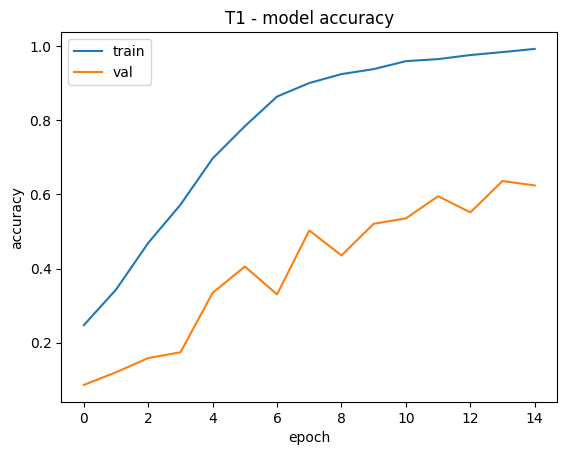

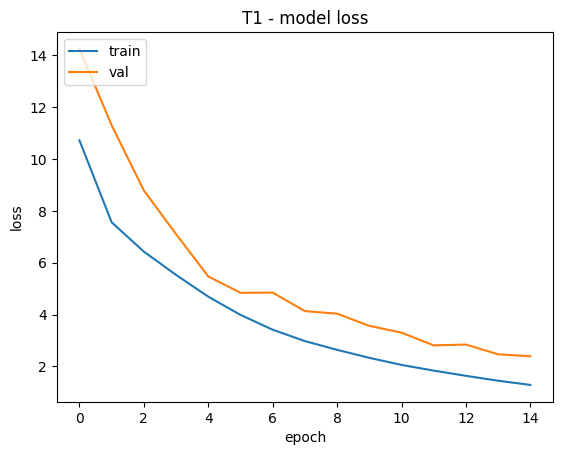

T1 - validation accuracy: 0.6242527961730957
37/37 [==============================] - 0s 8ms/step


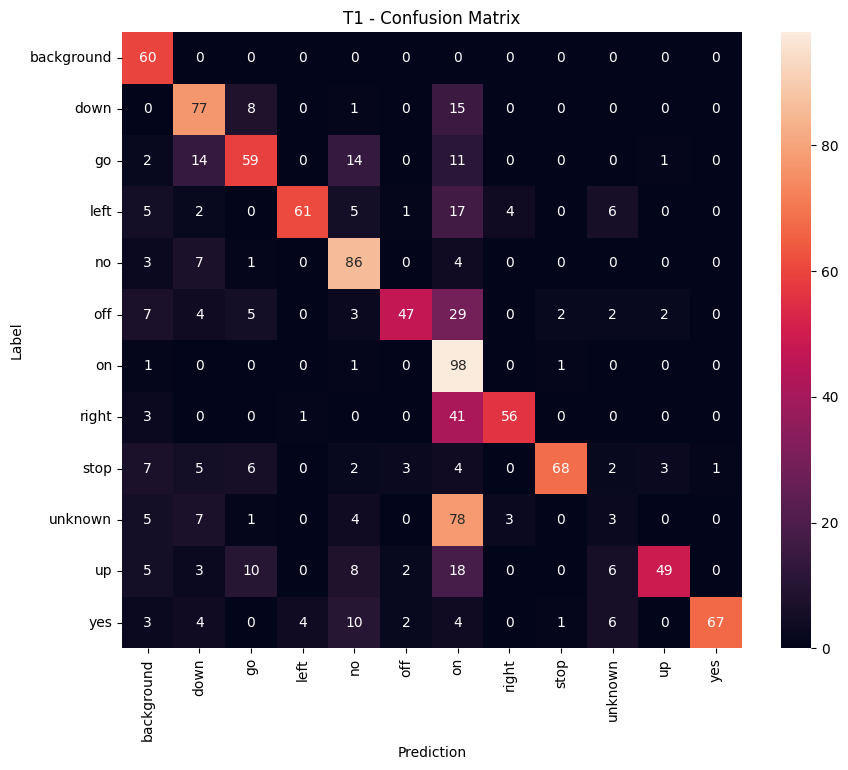

In [7]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('T1 - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('T1 - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Print accuracy
score = task1_model.evaluate(x_val, y_val, verbose=0)
print('T1 - validation accuracy:', score[1])

# Print confusion matrix
y_pred = task1_model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
class_labels = list(val_ds.class_names)
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('T1 - Confusion Matrix')
plt.show()


As we can see, the model is not performing well on the validation set, especially for the class 'unknown'. But that is expected as the class is a blanket of words not detected by any other classes.
Overall, this baseline model achieves a validation accuracy of around 0.6.

We now proceed to the next task.

#### Task 2: Random Search for Hyperparameter Tuning

We now use random search to find the best hyperparameters for the baseline model. Random search is better than grid search because it is faster and more efficient.
Here, we use the RandomSearchCV class from the scikit-learn library to find the best hyperparameters for the baseline model.

In [8]:
# define the random search parameters
param_grid = {
    'num_layers': hidden_num_layers,
    'num_filters': hidden_num_filters,
}

# Create a KerasClassifier
task2_model = KerasClassifier(model=t1_model, epochs=40, batch_size=BATCH_SIZE, verbose=1, num_layers=hidden_num_layers, num_filters=hidden_num_filters)

# Create a RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=task2_model, param_distributions=param_grid, n_iter=2, cv=3, verbose=2)

# Fit the RandomizedSearchCV
random_result = random_search.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/40
11/11 [==============================] - 8s 393ms/step - loss: 11.3078 - accuracy: 0.2264 - val_loss: 13.8767 - val_accuracy: 0.0931
Epoch 2/40
11/11 [==============================] - 2s 141ms/step - loss: 8.2811 - accuracy: 0.2879 - val_loss: 11.5925 - val_accuracy: 0.1178
Epoch 3/40
11/11 [==============================] - 1s 135ms/step - loss: 7.3522 - accuracy: 0.3598 - val_loss: 9.1822 - val_accuracy: 0.1776
Epoch 4/40
11/11 [==============================] - 1s 135ms/step - loss: 6.5350 - accuracy: 0.4558 - val_loss: 8.1694 - val_accuracy: 0.1067
Epoch 5/40
11/11 [==============================] - 1s 137ms/step - loss: 5.7682 - accuracy: 0.5840 - val_loss: 7.3425 - val_accuracy: 0.1119
Epoch 6/40
11/11 [==============================] - 1s 136ms/step - loss: 5.0496 - accuracy: 0.6769 - val_loss: 6.1923 - val_accuracy: 0.1827
Epoch 7/40
11/11 [==============================] - 1s 136ms/step - loss: 4.4414 - acc

As seen during the cross validation split of the Randomized Search for the best fit, the accuracy of the model has improved to 0.84.
The best values for the hyperparameters are:
* `num_layers`: 4
* `num_filters`: 128

We now redefine the model with these hyperparameters.

In [5]:
hidden_num_filters = [128, 128, 128, 128]
hidden_num_layers = [2, 3, 4, 5]

task2_model = t1_model(len(hidden_num_layers), hidden_num_filters, passthrough=True)
task2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 98, 50, 32)        320       
                                                                 
 batch_normalization_5 (Bat  (None, 98, 50, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 50, 128)       36992     
                                                                 
 batch_normalization_6 (Bat  (None, 98, 50, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 49, 25, 128)       0         
 g2D)                                                            
                                                      

#### Task 3: Model Averaging Scheme

Here, we randomly sample three subsets of the training data and train the T2 model on each of them. We then proceed with a series of voting schemes to determine the final prediction.

In [6]:
# define number of samples
train_samples = 2001

# create data index
data_index = list(range(1, train_samples))

subsets = 3

# keep track of history
shuffle_history = []

for i in range(subsets):
    # create random index using sampling with replacement
    idx = random.choices(data_index, k=train_samples)

    # define first shuffle
    x_train_shuffle = np.zeros([train_samples, IMG_SIZE[0], IMG_SIZE[1], 1])
    y_train_shuffle = np.zeros([train_samples, NUM_CLASSES])

    # resample the data
    for j in range(train_samples):
        x_train_shuffle[j] = x_train[idx[j], :, :, :]
        y_train_shuffle[j] = y_train[idx[j], :]

    # train the model
    shuffle_history.append(task2_model.fit(x_train_shuffle, y_train_shuffle, batch_size=BATCH_SIZE, epochs=40, validation_data=(x_val, y_val), callbacks=[early_stopping]))


# Take the majority class prediction and use the mode for all the three models to determine final prediction
# Create a matrix of predictions
y_pred = np.zeros([len(y_val), subsets])
# iterate through the models
for i in range(subsets):
    # save the predictions
    y_pred[:, i] = np.argmax(shuffle_history[i].model.predict(x_val), axis=1)

# convert to integer
y_pred = np.array(y_pred, dtype=int)
# take the mode
y_pred = np.squeeze(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=y_pred))

# Print accuracy of voting
y_true = np.argmax(y_val, axis=1)
correct = np.sum(y_pred == y_true)
accuracy = correct / len(y_true)
print('T3 - validation accuracy:', accuracy)

Epoch 1/40


2024-03-23 00:13:40.027134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-23 00:13:41.883785: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e116d3be5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-23 00:13:41.883802: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-23 00:13:41.890107: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711152821.957673   60527 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-23 00:13:45.903818: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.85GiB with freed_by_count=0. The caller

16/16 [==============================] - 14s 384ms/step - loss: 10.5268 - accuracy: 0.2379 - val_loss: 13.0460 - val_accuracy: 0.1042
Epoch 2/40
16/16 [==============================] - 2s 106ms/step - loss: 7.4847 - accuracy: 0.3738 - val_loss: 12.8581 - val_accuracy: 0.1178
Epoch 3/40
16/16 [==============================] - 2s 101ms/step - loss: 6.3181 - accuracy: 0.5262 - val_loss: 10.0934 - val_accuracy: 0.1375
Epoch 4/40
16/16 [==============================] - 2s 99ms/step - loss: 5.3007 - accuracy: 0.6882 - val_loss: 6.9649 - val_accuracy: 0.1939
Epoch 5/40
16/16 [==============================] - 2s 99ms/step - loss: 4.4512 - accuracy: 0.7891 - val_loss: 5.5706 - val_accuracy: 0.2827
Epoch 6/40
16/16 [==============================] - 2s 96ms/step - loss: 3.7577 - accuracy: 0.8821 - val_loss: 4.9216 - val_accuracy: 0.4022
Epoch 7/40
16/16 [==============================] - 2s 96ms/step - loss: 3.2523 - accuracy: 0.9270 - val_loss: 4.3547 - val_accuracy: 0.5073
Epoch 8/40
16/16

After resampling for three times, the accuracy drops to about 0.75.

This is maybe an indication that resampling with replacement reduces the overall accuracy of the model due to a drop in the amount of data available for training.

### Task 4: Hyperparameter Tuning using Bayesian Optimization

We now use Bayesian optimization to find the best hyperparameters for the advanced model.

Bayesian optimization is a probabilistic model-based optimization algorithm that is used to find the best hyperparameters for a model.

In [12]:
# Define the search space for hyperparameters
space = {'num_layers': hp.choice('num_layers', [1, 2, 3, 4, 5]),
    'num_filters': hp.choice('num_filters', [8, 16, 32, 64, 128]),}

# Define the objective function
def t4_model(params):
    # number of convolutional filters
    input_num_filters = 32
    fully_connected_num_filters = 1024

    # define model
    model = Sequential()

    # input layer
    model.add(Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
    model.add(Conv2D(input_num_filters, kernel_size =(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size =(2, 2), strides=(2, 2), padding='same'))

    # hidden layers
    for _ in range(params['num_layers']):
        model.add(Conv2D(params['num_filters'], kernel_size =(3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size =(2, 2), strides=(2, 2), padding='same'))

    # Time based pooling
    model.add(MaxPooling2D(pool_size=(TIMEPOOL_SIZE, 1), strides=(TIMEPOOL_SIZE, 1), padding='same'))

    # fully connected layer
    model.add(Flatten())
    model.add(Dense(fully_connected_num_filters, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dropout(0.2))

    # output layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # set adam optimizer
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # train the model
    model.fit(x_train, y_train, batch_size=int(BATCH_SIZE/6), epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping])

    # evaluate the model
    _, accuracy = model.evaluate(x_val, y_val, verbose=0)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Run the hyperparameter search
best = fmin(fn=t4_model, space=space, algo=tpe.suggest, max_evals=20)

# Print the best hyperparameters of number of layers and number of filters
print(space_eval(space, best))

Streaming output truncated to the last 5000 lines.
96/96 [==============================] - 2s 18ms/step - loss: 0.4758 - accuracy: 0.9195 - val_loss: 1.5420 - val_accuracy: 0.6396

Epoch 11/30

96/96 [==============================] - 2s 18ms/step - loss: 0.4272 - accuracy: 0.9290 - val_loss: 1.6089 - val_accuracy: 0.6302

Epoch 12/30

96/96 [==============================] - 1s 15ms/step - loss: 0.4518 - accuracy: 0.9085 - val_loss: 1.8827 - val_accuracy: 0.5901

Epoch 13/30

96/96 [==============================] - 1s 14ms/step - loss: 0.3828 - accuracy: 0.9310 - val_loss: 1.6588 - val_accuracy: 0.6678

Epoch 14/30

96/96 [==============================] - 1s 14ms/step - loss: 0.3815 - accuracy: 0.9290 - val_loss: 1.6870 - val_accuracy: 0.6729

Epoch 15/30

96/96 [==============================] - 1s 15ms/step - loss: 0.3531 - accuracy: 0.9365 - val_loss: 1.7403 - val_accuracy: 0.6721

Epoch 16/30

96/96 [==============================] - 1s 14ms/step - loss: 0.3079 - accuracy: 0.94

The Bayesian optimization gives us the best hyperparameters for the advanced model as:
* `num_layers`: 4
* `num_filters`: 128

Overall, the accuracy of the advanced model is about as similar as Model Averaging at 0.72. This seems to find the best parameters as that of Random Search. But there is a drop in accuracy during pursuit of these hyperparameters. This can be due to overtraining the model leading to a overfitted model.

#### Task 5: Data Augmentation, Model Validation of Personal Voice Recordings, and Transfer Learning

First we record our own voice for about 10 times in two classes 'yes' and 'no'. We also ensure that the recordings are of the same length as the dataset recordings, which is of 1s each.


We augment the data by adding random noise to the recordings to generate more data. We randomly add 5% noise to the recordings.

In [14]:
!unzip /content/personalRecordings.zip

Archive:  /content/personalRecordings.zip
   creating: personalRecordings/
   creating: personalRecordings/no/
  inflating: personalRecordings/no/0.wav  
  inflating: personalRecordings/no/1.wav  
  inflating: personalRecordings/no/2.wav  
  inflating: personalRecordings/no/3.wav  
  inflating: personalRecordings/no/4.wav  
  inflating: personalRecordings/no/5.wav  
  inflating: personalRecordings/no/6.wav  
  inflating: personalRecordings/no/7.wav  
  inflating: personalRecordings/no/8.wav  
  inflating: personalRecordings/no/9.wav  
  inflating: personalRecordings/no/0_with_noise_0.wav  
  inflating: personalRecordings/no/0_with_noise_1.wav  
  inflating: personalRecordings/no/1_with_noise_0.wav  
  inflating: personalRecordings/no/1_with_noise_1.wav  
  inflating: personalRecordings/no/2_with_noise_0.wav  
  inflating: personalRecordings/no/2_with_noise_1.wav  
  inflating: personalRecordings/no/3_with_noise_0.wav  
  inflating: personalRecordings/no/3_with_noise_1.wav  
  inflating

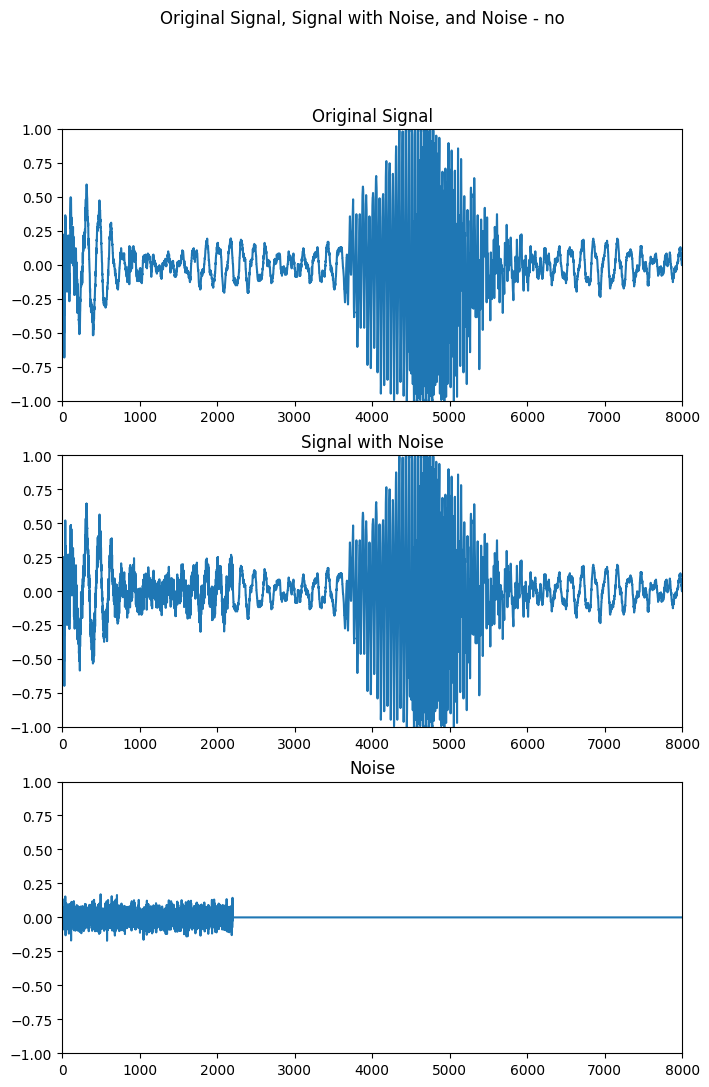

In [20]:
recorded_classes = ['no', 'yes']
num_recordings = 10
num_synthetic_recordings = 2
noise_percentage = 0.01

viewing_label = True

for word in recorded_classes:
    for i in range(num_recordings):
        sound_path = f'personalRecordings/{word}/{i}.wav'

        # trim the audio file to 1 second
        sound = AudioSegment.from_file(sound_path)
        sound = sound[:1000]
        sound.export(sound_path, format="wav")

        # capture the signal and sample rate
        signal, sr = librosa.load(sound_path, sr=8000)

        for j in range(num_synthetic_recordings):
            # add noise to the signal to only a part of the signal
            random_index = random.randint(0, len(signal) - 1)
            noise = np.random.normal(0, noise_percentage, random_index)
            signal_with_noise = signal.copy()
            signal_with_noise[:random_index] += noise

            signal_noise = signal_with_noise - signal

            # export the signal with noise
            sound_with_noise_path = f'personalRecordings/{word}/{i}_with_noise_{j}.wav'
            sf.write(sound_with_noise_path, signal_with_noise, sr)

        if viewing_label:
            viewing_label = False
            # use subplots to plot the original signal, signal with noise and noise
            fig, axs = plt.subplots(3, figsize=(8, 12))
            fig.suptitle(f'Original Signal, Signal with Noise, and Noise - {word}')

            # set x-axis and y-axis limits
            axs[0].set_xlim(0, len(signal))
            axs[0].set_ylim(-1, 1)

            axs[1].set_xlim(0, len(signal))
            axs[1].set_ylim(-1, 1)

            axs[2].set_xlim(0, len(signal))
            axs[2].set_ylim(-1, 1)

            axs[0].plot(signal)
            axs[0].set_title('Original Signal')
            axs[1].plot(signal_with_noise)
            axs[1].set_title('Signal with Noise')
            axs[2].plot(signal_noise)
            axs[2].set_title('Noise')
            plt.show()






As you can see, random indices are chosen to add noise to the recordings. So, for every iteration, the noise added to the recordings is different.

We now convert the recordings to spectrograms and use the advanced model to predict the classes of the recordings. This is done by the helper script provided in MATLAB.

First let's analyze the confusion matrix of the model on the personal recordings.

#### T5.1 Analysis of Confusion matrix on 'yes' and 'no' classes on Advanced Model:

We now use the random search model hyperparameters to baseoff our personal recordings against.

In [46]:
task5_model = t1_model(len([2, 3, 4, 5]), [128, 128, 128, 128], passthrough=True)
task5_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_146 (Conv2D)         (None, 98, 50, 32)        320       
                                                                 
 batch_normalization_146 (B  (None, 98, 50, 32)        128       
 atchNormalization)                                              
                                                                 
 conv2d_147 (Conv2D)         (None, 98, 50, 128)       36992     
                                                                 
 batch_normalization_147 (B  (None, 98, 50, 128)       512       
 atchNormalization)                                              
                                                                 
 max_pooling2d_167 (MaxPool  (None, 49, 25, 128)       0         
 ing2D)                                                          
                                                     

Epoch 1/30
16/16 [==============================] - 2s 136ms/step - loss: 5.5834 - accuracy: 0.5892 - val_loss: 10.4304 - val_accuracy: 0.1126
Epoch 2/30
16/16 [==============================] - 2s 130ms/step - loss: 4.7417 - accuracy: 0.7014 - val_loss: 8.3976 - val_accuracy: 0.1135
Epoch 3/30
16/16 [==============================] - 2s 134ms/step - loss: 4.0281 - accuracy: 0.7934 - val_loss: 5.3865 - val_accuracy: 0.2049
Epoch 4/30
16/16 [==============================] - 2s 131ms/step - loss: 3.4725 - accuracy: 0.8492 - val_loss: 4.5652 - val_accuracy: 0.3920
Epoch 5/30
16/16 [==============================] - 2s 133ms/step - loss: 3.0350 - accuracy: 0.8927 - val_loss: 4.2441 - val_accuracy: 0.4809
Epoch 6/30
16/16 [==============================] - 2s 133ms/step - loss: 2.6832 - accuracy: 0.9155 - val_loss: 3.6706 - val_accuracy: 0.5893
Epoch 7/30
16/16 [==============================] - 2s 133ms/step - loss: 2.3489 - accuracy: 0.9496 - val_loss: 3.2630 - val_accuracy: 0.6367
Epoch

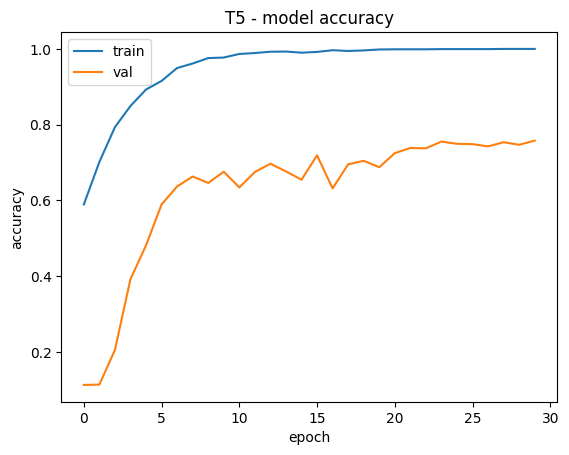

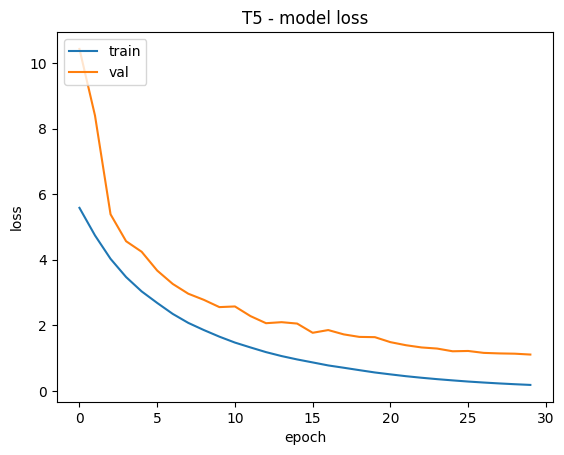

T5 - validation accuracy: 0.7578323483467102
37/37 [==============================] - 0s 8ms/step


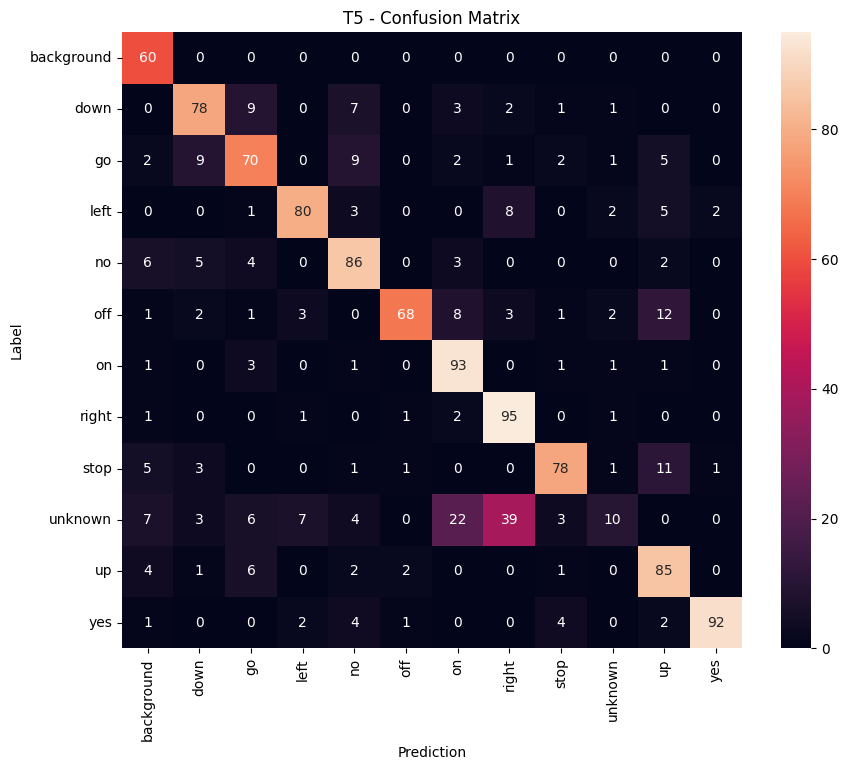

In [48]:
task5_history = task5_model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=30, validation_data=(x_val, y_val))

# summarize history for accuracy
plt.plot(task5_history.history['accuracy'])
plt.plot(task5_history.history['val_accuracy'])
plt.title('T5 - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(task5_history.history['loss'])
plt.plot(task5_history.history['val_loss'])
plt.title('T5 - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Print accuracy
score = task5_model.evaluate(x_val, y_val, verbose=0)
print('T5 - validation accuracy:', score[1])

# Print confusion matrix
y_pred = task5_model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
class_labels = list(val_ds.class_names)
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('T5 - Confusion Matrix')
plt.show()


As, we can observe:
* The model is able to predict the 'yes' class with an accuracy of 0.8.
* The model is able to predict the 'no' class with an accuracy of 0.6.

#### T5.2 Training the Advanced Model on the Personal Recordings:
We now move the spectrograms to the training and validation directories and train the advanced model on the personal recordings.

In [49]:
recrd_train_imgs = 12
recrd_val_imgs = 6

no_src_path = 'spectrogramImages/no'
yes_src_path = 'spectrogramImages/yes'

for i in range(1, recrd_train_imgs):
    shutil.copy(no_src_path + f'/{i}.png', f'speechImageData/TrainData/no/image_train_{1661 + i}.png')
    shutil.copy(yes_src_path + f'/{i + 12}.png', f'speechImageData/TrainData/yes/image_train_{1672 + i}.png')

for i in range(1, recrd_val_imgs):
    shutil.copy(no_src_path + f'/{i + 12}.png', f'speechImageData/ValData/no/image_val_{1111 + i}.png')
    shutil.copy(yes_src_path + f'/{i + 24}.png', f'speechImageData/ValData/yes/image_val_{1116 + i}.png')

We create new instance of x_train, y_train, x_val, y_val and train the advanced model on the personal recordings.

In [50]:
# Load the data

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData/TrainData',
    labels='inferred',
    color_mode="grayscale",
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData/ValData',
    labels='inferred',
    color_mode="grayscale",
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Extract the training input images and output class labels
x_train = []
y_train = []
for images, labels in train_ds.take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train_recrd = np.concatenate(x_train, axis=0)
y_train_recrd = np.concatenate(y_train, axis=0)

print(y_train_recrd)

# Extract the validation input images and output class labels
x_val = []
y_val = []
for images, labels in val_ds.take(-1):
    x_val.append(images.numpy())
    y_val.append(labels.numpy())

x_val_recrd = np.concatenate(x_val, axis=0)
y_val_recrd = np.concatenate(y_val, axis=0)

print(y_val_recrd)


Found 2023 files belonging to 12 classes.
Found 1181 files belonging to 12 classes.
[[0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


We now plot the training history and confusion matrix of the advanced model on the personal recordings.

Epoch 1/30
16/16 [==============================] - 2s 140ms/step - loss: 0.1636 - accuracy: 1.0000 - val_loss: 1.1288 - val_accuracy: 0.7502
Epoch 2/30
16/16 [==============================] - 2s 135ms/step - loss: 0.1466 - accuracy: 1.0000 - val_loss: 1.0800 - val_accuracy: 0.7511
Epoch 3/30
16/16 [==============================] - 2s 134ms/step - loss: 0.1313 - accuracy: 1.0000 - val_loss: 1.0681 - val_accuracy: 0.7621
Epoch 4/30
16/16 [==============================] - 2s 134ms/step - loss: 0.1177 - accuracy: 1.0000 - val_loss: 1.0858 - val_accuracy: 0.7511
Epoch 5/30
16/16 [==============================] - 2s 131ms/step - loss: 0.1064 - accuracy: 1.0000 - val_loss: 1.0604 - val_accuracy: 0.7426
Epoch 6/30
16/16 [==============================] - 2s 134ms/step - loss: 0.0960 - accuracy: 1.0000 - val_loss: 1.0253 - val_accuracy: 0.7451
Epoch 7/30
16/16 [==============================] - 2s 132ms/step - loss: 0.0859 - accuracy: 1.0000 - val_loss: 1.0414 - val_accuracy: 0.7519
Epoch 

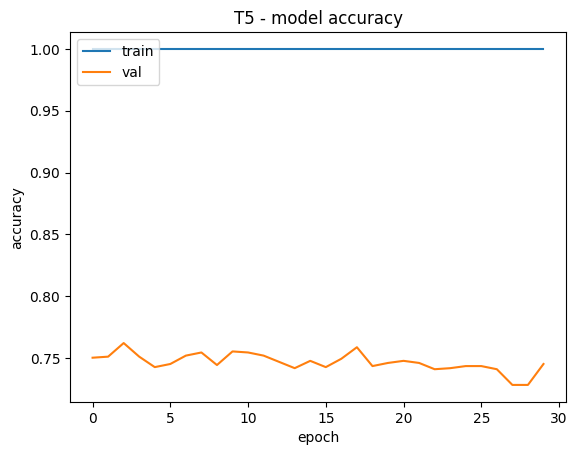

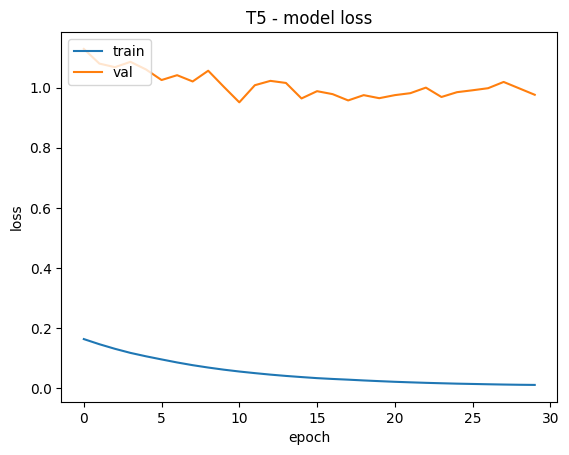

T5 - validation accuracy: 0.745131254196167
37/37 [==============================] - 0s 8ms/step


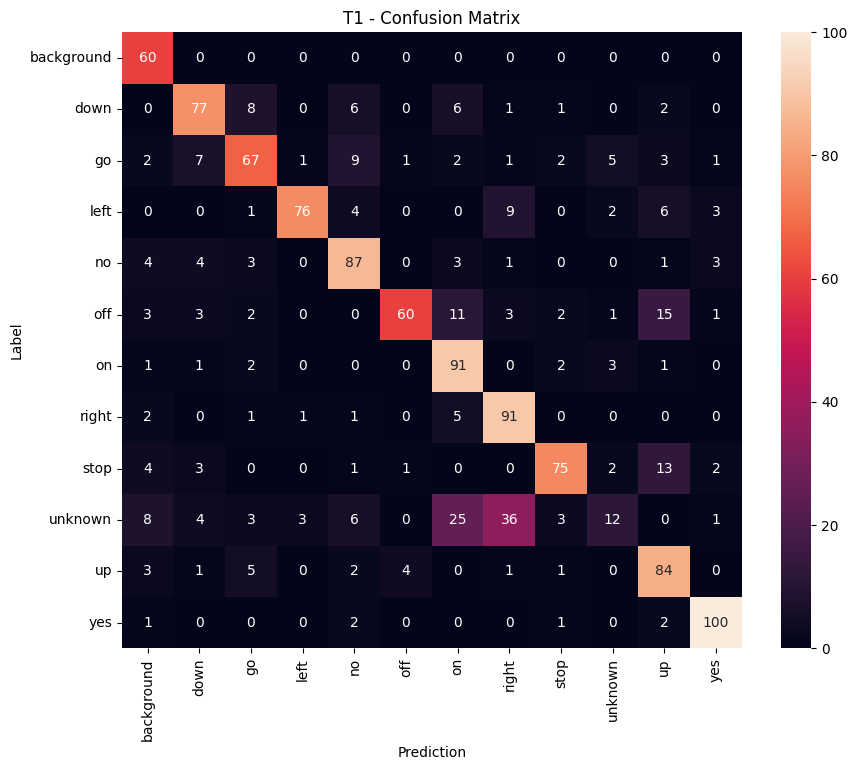

In [51]:
task5_history = task5_model.fit(x_train_recrd, y_train_recrd, batch_size=BATCH_SIZE, epochs=30, validation_data=(x_val_recrd, y_val_recrd))

# summarize history for accuracy
plt.plot(task5_history.history['accuracy'])
plt.plot(task5_history.history['val_accuracy'])
plt.title('T5 - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(task5_history.history['loss'])
plt.plot(task5_history.history['val_loss'])
plt.title('T5 - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Print accuracy
score = task5_model.evaluate(x_val_recrd, y_val_recrd, verbose=0)
print('T5 - validation accuracy:', score[1])

# Print confusion matrix
y_pred = task5_model.predict(x_val_recrd)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_recrd, axis=1)
class_labels = list(val_ds.class_names)
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('T1 - Confusion Matrix')
plt.show()

As observed, there is an increased match in both the classes, 'yes' and 'no' with the model's predictions.
There is no dramatic drop of accuracy in these classes, and hence the data augmentation has helped in improving the model's performance.

#### T5.3 Transfer Learning using the Advanced Model

We now use the popular model mobilenetv2 to perform transfer learning on the advanced model.
Since the model requires the image size to be either 96x96, 128x128, 224x224, we resize the images to 96x96, since our original image size is 98x50.

We also reimport our training and validation data as three channeled rgb images instead of grayscale.

In [55]:
# Load the data

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData/TrainData',
    labels='inferred',
    color_mode="rgb",
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData/ValData',
    labels='inferred',
    color_mode="rgb",
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Extract the training input images and output class labels
x_train = []
y_train = []
for images, labels in train_ds.take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train_recrd = np.concatenate(x_train, axis=0)
y_train_recrd = np.concatenate(y_train, axis=0)

print(y_train_recrd)

# Extract the validation input images and output class labels
x_val = []
y_val = []
for images, labels in val_ds.take(-1):
    x_val.append(images.numpy())
    y_val.append(labels.numpy())

x_val_recrd = np.concatenate(x_val, axis=0)
y_val_recrd = np.concatenate(y_val, axis=0)

print(y_val_recrd)

Found 2023 files belonging to 12 classes.
Found 1181 files belonging to 12 classes.
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [56]:
# mobilenet image size
MOBILENET_IMG_SIZE = (96, 96)

# resize the images
x_train_recrd = tf.image.resize(x_train_recrd, (MOBILENET_IMG_SIZE[0], MOBILENET_IMG_SIZE[1]))
x_val_recrd = tf.image.resize(x_val_recrd, (MOBILENET_IMG_SIZE[0], MOBILENET_IMG_SIZE[1]))

base_model = MobileNetV2(input_shape=(MOBILENET_IMG_SIZE[0], MOBILENET_IMG_SIZE[1], 3), include_top=False, weights='imagenet')

x_train_recrd = preprocess_input(x_train_recrd)
x_val_recrd = preprocess_input(x_val_recrd)

# extract features
train_features = base_model.predict(x_train_recrd)
val_features = base_model.predict(x_val_recrd)

37/37 [==============================] - 0s 11ms/step


We now define the base model for training. We just append the fully connected layer to the base model and output layer to the model.

In [62]:
mobilenet_model = Sequential()
mobilenet_model.add(Flatten(input_shape=train_features.shape[1:]))
mobilenet_model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
mobilenet_model.add(Dropout(0.2))
mobilenet_model.add(Dense(NUM_CLASSES, activation='softmax'))
mobilenet_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_40 (Flatten)        (None, 11520)             0         
                                                                 
 dense_80 (Dense)            (None, 1024)              11797504  
                                                                 
 dropout_40 (Dropout)        (None, 1024)              0         
                                                                 
 dense_81 (Dense)            (None, 12)                12300     
                                                                 
Total params: 11809804 (45.05 MB)
Trainable params: 11809804 (45.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### T5.A - Model Training

Now, we proceed to train the model with the training and validation features extracted by the base model.

In [63]:
mobilenet_model.history = mobilenet_model.fit(train_features, y_train_recrd, batch_size=BATCH_SIZE, epochs=100, validation_data=(val_features, y_val_recrd))

Epoch 1/100
16/16 [==============================] - 1s 33ms/step - loss: 176.4016 - accuracy: 0.3381 - val_loss: 160.5809 - val_accuracy: 0.3404
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 147.2709 - accuracy: 0.5971 - val_loss: 134.0095 - val_accuracy: 0.3903
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 122.2296 - accuracy: 0.6945 - val_loss: 111.3102 - val_accuracy: 0.4039
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 100.9884 - accuracy: 0.7904 - val_loss: 92.1280 - val_accuracy: 0.4479
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 83.2079 - accuracy: 0.8492 - val_loss: 76.0616 - val_accuracy: 0.4335
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 68.3979 - accuracy: 0.8962 - val_loss: 62.7798 - val_accuracy: 0.4403
Epoch 7/100
16/16 [==============================] - 0s 15ms/step - loss: 56.1458 - accuracy: 0.9288 - val_loss: 51.8201 - val_ac

#### T5.B - Plot Training History and Confusion Matrix

Here, we plot the training history and confusion matrix of the advanced model with transfer learning.

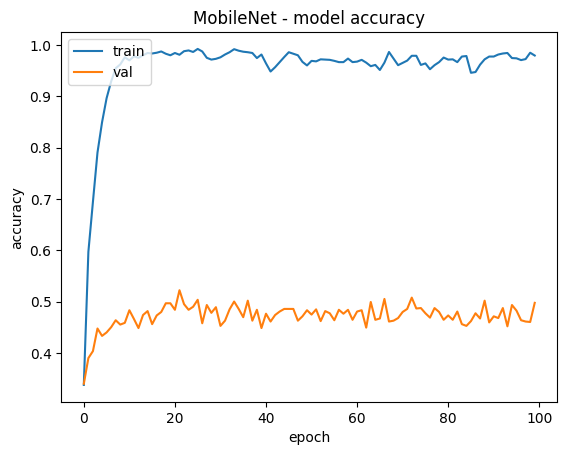

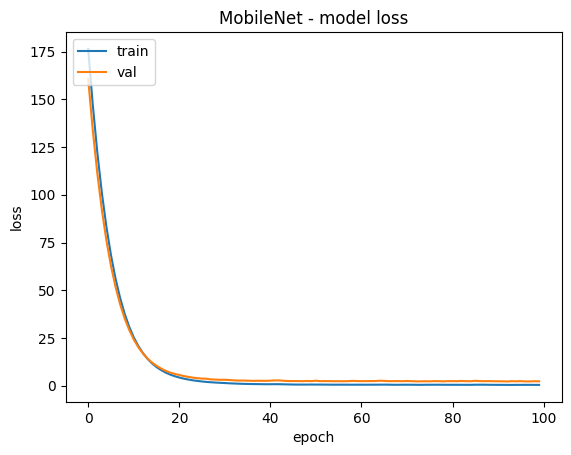

MobileNet - validation accuracy: 0.497883141040802
37/37 [==============================] - 0s 3ms/step


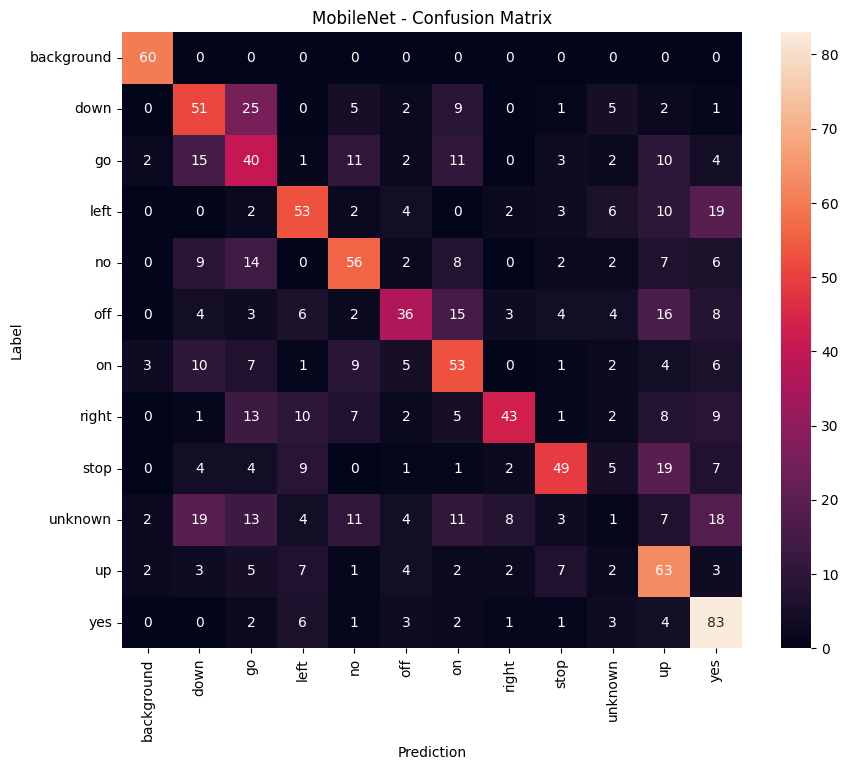

In [64]:
# summarize history for accuracy
plt.plot(mobilenet_model.history.history['accuracy'])
plt.plot(mobilenet_model.history.history['val_accuracy'])
plt.title('MobileNet - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(mobilenet_model.history.history['loss'])
plt.plot(mobilenet_model.history.history['val_loss'])
plt.title('MobileNet - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Print accuracy
score = mobilenet_model.evaluate(val_features, y_val_recrd, verbose=0)
print('MobileNet - validation accuracy:', score[1])

# Print confusion matrix
y_pred = mobilenet_model.predict(val_features)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_recrd, axis=1)
class_labels = list(val_ds.class_names)
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('MobileNet - Confusion Matrix')
plt.show()


#### T5.C - Conclusion
The transfer learning model has a poor accuracy of about 0.5. This is because the model is not able to learn the features of the personal recordings well due to the resizing constraint of the model.
The resizing jump from 98x50 to 96x96 has caused the model to lose the features of the spectrograms, and hence the model is not able to predict the classes well.

Future steps to improve the model would be taking inspiration of the model's architecture in the transfer learning model and training a new model with the same architecture as the base model without the resizing constraint.

## Overall Conclusion

The advanced model has an accuracy of about 0.84, which is better than the baseline model's accuracy of 0.6. The advanced model is able to predict the classes of the personal recordings with an accuracy of 0.8 for the 'yes' class and 0.6 for the 'no' class.

Additionally, the transfer learning model has a poor accuracy of about 0.5. This is because the model is not able to learn the features of the personal recordings well due to the resizing constraint of the model.
All of the above code, helper scripts and data are available in my personal [GitHub repository](https://github.com/UoS-MSc-Robotics/deep_learning_lab/tree/main).